In [2]:
import os
import pandas as pd 
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import json
import joblib

from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, roc_auc_score, auc

from sklearn.inspection import permutation_importance

In [3]:
df = pd.read_csv("lead_data_expanded.csv")
df.columns

Index(['School_District', 'School', 'County', 'num_lte_5ppb', 'num_gt_5ppb',
       'School_City', 'Ratio_free', 'Student_teacher_ratio',
       'American_Indian/Alaska_Native', 'Asian', 'Black', 'Hispanic', 'White',
       'Native_Hawaiian/Pacific_Islander', 'Two_or_More_Races', 'target_col',
       'percent_housing_pre_1950'],
      dtype='object')

In [4]:
df_copied = df.copy()

### Recreate Train Test Split

In [5]:
X = df_copied.drop(columns=['target_col','num_gt_5ppb','School', 'County', 'num_lte_5ppb']) 
y = df_copied['target_col']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=40, stratify=y,)
X_train_t, X_train_v, y_train_t, y_train_v = train_test_split(X_train, y_train, test_size=0.2, random_state=40, stratify=y_train)

In [6]:
X.columns

Index(['School_District', 'School_City', 'Ratio_free', 'Student_teacher_ratio',
       'American_Indian/Alaska_Native', 'Asian', 'Black', 'Hispanic', 'White',
       'Native_Hawaiian/Pacific_Islander', 'Two_or_More_Races',
       'percent_housing_pre_1950'],
      dtype='object')

In [7]:
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

### Pipeline

In [8]:
num_transformer = Pipeline([('imputer',SimpleImputer(strategy='median')), ('scaler',StandardScaler())])
cat_transformer = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num',num_transformer,num_features),('cat', cat_transformer,cat_features)])

### Random Forest with Hyperparameter Tuning

In [9]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [10]:
from scipy.stats import uniform, randint

In [11]:
# parameter distributions

param_distributions = {
    "classifier__n_estimators": randint(50, 500),
    "classifier__max_depth": randint(2, 50),
    "classifier__max_features": uniform(0.1, 0.9),
    "classifier__min_samples_split": randint(2, 10),
    "classifier__min_samples_leaf": randint(1, 10),
    "classifier__bootstrap": [True, False]
}

# model
RF = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=40))
])

In [12]:
# for storing data 
outer_cv_RF = KFold(n_splits=5, shuffle=True, random_state=40)
nested_RF_scores = []
inner_RF_cv_scores = []
best_RF_parameters = []
roc_curves = []

# to store true and predicted values across outer fold
RF_y_true_all = []
RF_y_pred_all = []


In [13]:
# nested cross-validation
for fold_idx, (train_idx, test_idx) in enumerate(outer_cv_RF.split(X), start=1):
    X_outer_train, X_outer_test = X.iloc[train_idx], X.iloc[test_idx]
    y_outer_train, y_outer_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Inner CV for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=40)
    RF_inner_search = RandomizedSearchCV(
        RF,
        param_distributions,
        n_iter=100,
        cv=inner_cv,
        scoring='roc_auc',
        random_state=40,
        n_jobs=-1
    )
    RF_inner_search.fit(X_outer_train, y_outer_train)

    inner_RF_cv_scores.append(float(RF_inner_search.best_score_))

    
    # Evaluate best model on outer test fold
    best_inner_model = clone(RF_inner_search.best_estimator_)
    best_inner_model.fit(X_outer_train, y_outer_train)
    y_pred_outer = best_inner_model.predict(X_outer_test)
    y_proba_outer = best_inner_model.predict_proba(X_outer_test)[:,1]
    roc = roc_auc_score(y_outer_test, y_pred_outer)

    # store the best parameters from each inner CV
    best_RF_parameters.append(RF_inner_search.best_params_)

    # store data
    nested_RF_scores.append(roc)
    RF_y_true_all.extend(y_outer_test)
    RF_y_pred_all.extend(y_pred_outer)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_outer_test, y_proba_outer)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr,tpr))


# Print Accuracies and Best Parameters
print("Inner fold ROC scores:", inner_RF_cv_scores)
print("Outer fold ROC scores:", nested_RF_scores)
print("Mean ROC scores:", np.mean(nested_RF_scores))
print(f"Fold {fold_idx}), Best Parameters: {best_RF_parameters}, ROC-AUC: {roc:0.4f}")




Inner fold ROC scores: [0.7548472215019265, 0.7530388001296622, 0.7496939576859424, 0.7652708699626509, 0.7518262733813689]
Outer fold ROC scores: [0.7080525921766797, 0.7183648195530008, 0.7253196840352804, 0.7268125581231091, 0.7509893293760157]
Mean ROC scores: 0.7259077966528171
Fold 5), Best Parameters: [{'classifier__bootstrap': False, 'classifier__max_depth': 42, 'classifier__max_features': np.float64(0.11018579097545961), 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 364}, {'classifier__bootstrap': False, 'classifier__max_depth': 42, 'classifier__max_features': np.float64(0.11018579097545961), 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 364}, {'classifier__bootstrap': True, 'classifier__max_depth': 31, 'classifier__max_features': np.float64(0.3884781006534881), 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 430}, {'class

In [15]:
# Turn best_RF_parameters (list of dicts) into a df for easy reading
best_RF_params_df = pd.DataFrame(best_RF_parameters)

# add a column for the outer fold number
best_RF_params_df['outer_fold'] = range(1, len(best_RF_parameters) + 1)

# reorder columns so fold number is first
cols = ['outer_fold'] + [c for c in best_RF_params_df.columns if c != 'outer_fold']
best_RF_params_df = best_RF_params_df[cols]

print(best_RF_params_df)

   outer_fold  classifier__bootstrap  classifier__max_depth  \
0           1                  False                     42   
1           2                  False                     42   
2           3                   True                     31   
3           4                  False                     42   
4           5                   True                     31   

   classifier__max_features  classifier__min_samples_leaf  \
0                  0.110186                             2   
1                  0.110186                             2   
2                  0.388478                             1   
3                  0.110186                             2   
4                  0.388478                             1   

   classifier__min_samples_split  classifier__n_estimators  
0                              6                       364  
1                              6                       364  
2                              5                       430  
3         

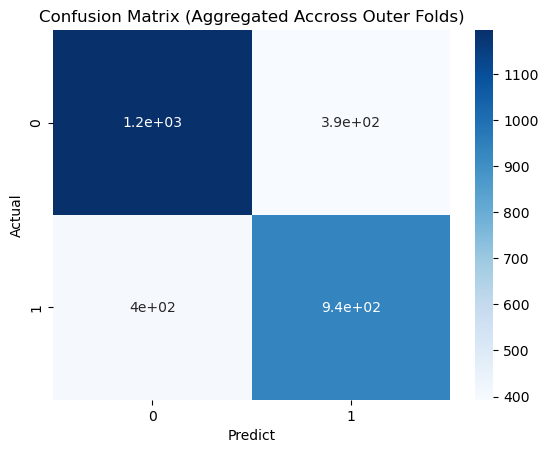

In [16]:
# Aggregate Confusion Matrix

cm = confusion_matrix(RF_y_true_all, RF_y_pred_all)
sns.heatmap(cm,annot=True, cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Aggregated Accross Outer Folds)')
plt.show()

### ROC Curves

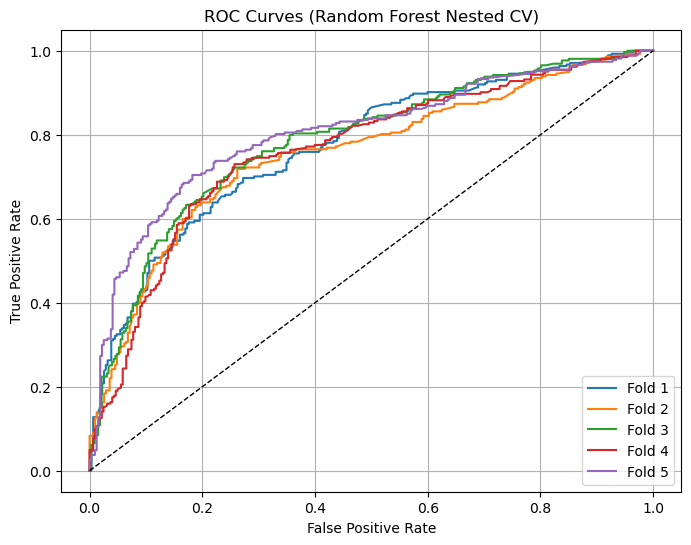

In [17]:
# Plot ROC curves for all folds
plt.figure(figsize=(8,6))
for i, (fpr, tpr) in enumerate(roc_curves, 1):
    plt.plot(fpr, tpr, label=f'Fold {i}')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Random Forest Nested CV)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Random Forest Feature Importance

In [18]:
# # set RF_model to be best_inner_model from nested CV trained pipeline
RF_model = best_inner_model  

# Extract feature names from the ColumnTransformer
## note names of num_features not transformed in pipeline
## for categorical features, get names after OneHotEncoder
cat_features_names = RF_model.named_steps['preprocessor'] \
                         .named_transformers_['cat'] \
                         .named_steps['onehot'] \
                         .get_feature_names_out(cat_features)

# combine feature names
all_feature_names = list(num_features) + list(cat_features_names)

# note this code was used previously for categorical features

In [19]:
# extract most import features
RF_model = best_inner_model  

importances = RF_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))

                           Feature  Importance
196        School_District_nyc_doe    0.102994
0                       Ratio_free    0.076356
1            Student_teacher_ratio    0.076029
6                            White    0.073680
9         percent_housing_pre_1950    0.072646
5                         Hispanic    0.070225
3                            Asian    0.066066
4                            Black    0.062748
8                Two_or_More_Races    0.061599
2    American_Indian/Alaska_Native    0.053403


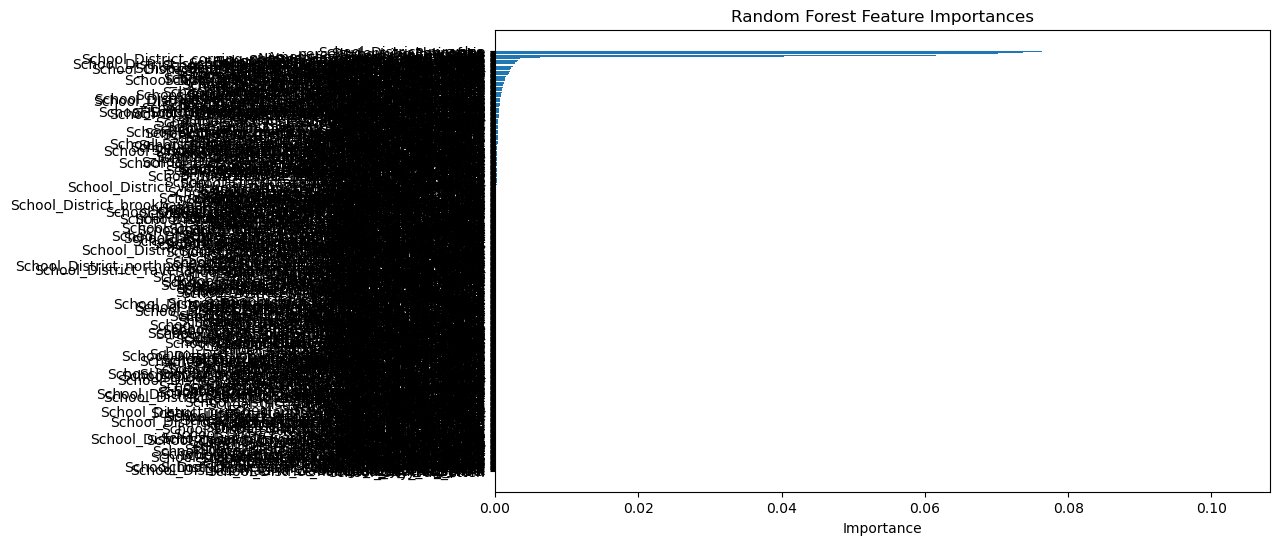

In [21]:
# Plot feature importance

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # puts most important on top
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()